In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the dataset
data = pd.read_csv("./R02_Data.csv")

# Display basic information about the dataset
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974836 entries, 0 to 974835
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   _time                     974836 non-null  object 
 1   I_R02_Gripper_Load        974836 non-null  int64  
 2   I_R02_Gripper_Pot         974836 non-null  int64  
 3   M_R02_BJointAngle_Degree  974836 non-null  float64
 4   M_R02_LJointAngle_Degree  974836 non-null  float64
 5   M_R02_RJointAngle_Degree  974836 non-null  float64
 6   M_R02_SJointAngle_Degree  974836 non-null  float64
 7   M_R02_TJointAngle_Degree  974836 non-null  float64
 8   M_R02_UJointAngle_Degree  974836 non-null  float64
 9   Description               492728 non-null  object 
dtypes: float64(6), int64(2), object(2)
memory usage: 74.4+ MB
None
                      _time  I_R02_Gripper_Load  I_R02_Gripper_Pot  \
0  2023-12-11T13:04:12.348Z                1299              11695   
1  2023-1

C:\Users\Alireza Vaezi\AppData\Local\Temp\ipykernel_37896\978901404.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("./R02_Data.csv")


In [3]:
# Handle missing data
# Drop the 'Description' column if it is not relevant for analysis
if "Description" in data.columns:
    data.drop(columns=["Description"], inplace=True)

# Check for any other missing values in the dataset
missing_summary = data.isnull().sum()
print("Missing Values Summary:")
print(missing_summary)

Missing Values Summary:
_time                       0
I_R02_Gripper_Load          0
I_R02_Gripper_Pot           0
M_R02_BJointAngle_Degree    0
M_R02_LJointAngle_Degree    0
M_R02_RJointAngle_Degree    0
M_R02_SJointAngle_Degree    0
M_R02_TJointAngle_Degree    0
M_R02_UJointAngle_Degree    0
dtype: int64


In [4]:
# Convert `_time` to datetime for efficient time-based operations
data["_time"] = pd.to_datetime(data["_time"], errors="coerce")

# Check for successful conversion
print(data["_time"].head())

0   2023-12-11 13:04:12.348000+00:00
1   2023-12-11 13:04:12.439000+00:00
2   2023-12-11 13:04:12.541000+00:00
3   2023-12-11 13:04:12.637000+00:00
4   2023-12-11 13:04:12.743000+00:00
Name: _time, dtype: datetime64[ns, UTC]


In [6]:
# Strip timezone information
data["_time"] = data["_time"].dt.tz_localize(None)

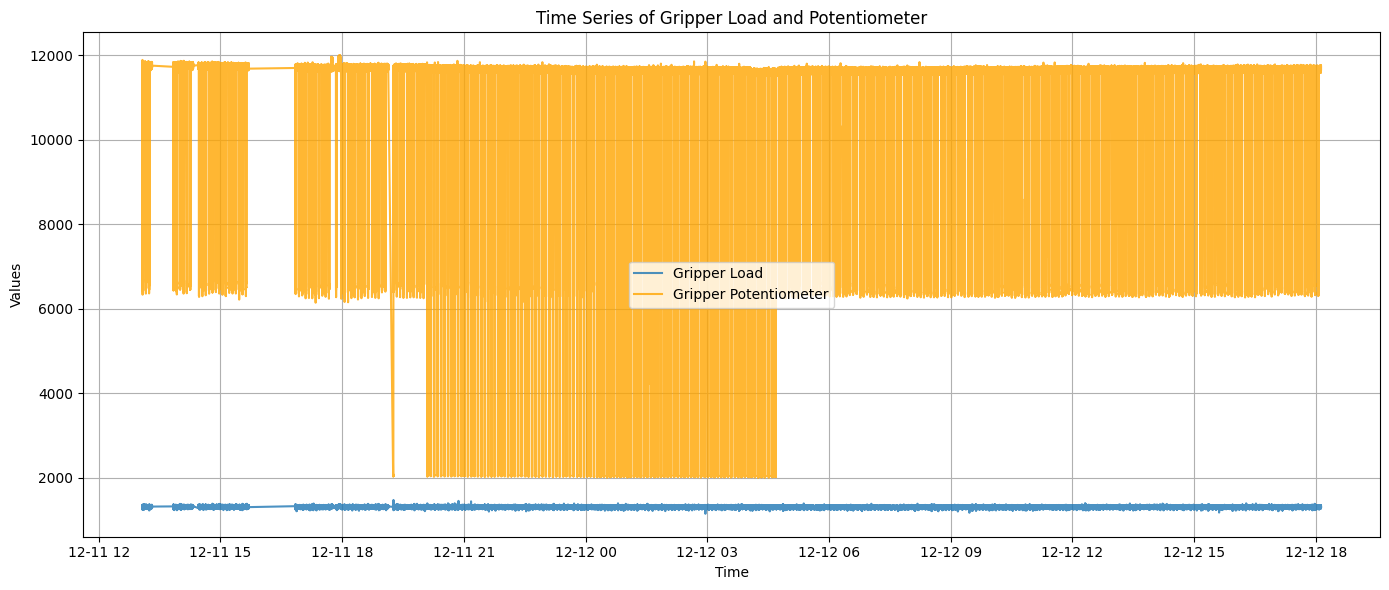

In [7]:
# Plot time-series data for gripper load and potentiometer values
plt.figure(figsize=(14, 6))

plt.plot(data["_time"], data["I_R02_Gripper_Load"], label="Gripper Load", alpha=0.8)
plt.plot(data["_time"], data["I_R02_Gripper_Pot"], label="Gripper Potentiometer", alpha=0.8, color="orange")

plt.title("Time Series of Gripper Load and Potentiometer")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
from scipy.stats import zscore

# Calculate Z-scores for both features
data["Load_Zscore"] = zscore(data["I_R02_Gripper_Load"])
data["Pot_Zscore"] = zscore(data["I_R02_Gripper_Pot"])

# Define a threshold (e.g., 3 standard deviations)
threshold = 3

# Flag anomalies where the absolute Z-score is greater than the threshold
data["Load_Anomaly"] = data["Load_Zscore"].abs() > threshold
data["Pot_Anomaly"] = data["Pot_Zscore"].abs() > threshold

# Count anomalies
load_anomalies = data["Load_Anomaly"].sum()
pot_anomalies = data["Pot_Anomaly"].sum()
print(f"Gripper Load Anomalies: {load_anomalies}")
print(f"Gripper Potentiometer Anomalies: {pot_anomalies}")

Gripper Load Anomalies: 3755
Gripper Potentiometer Anomalies: 26615


In [9]:
from sklearn.ensemble import IsolationForest

# Fit Isolation Forest on selected features
iso_forest = IsolationForest(contamination=0.01, random_state=42)
data["Anomaly_IF"] = iso_forest.fit_predict(data[["I_R02_Gripper_Load", "I_R02_Gripper_Pot"]])

# Anomalies are marked as -1
data["IsolationForest_Anomaly"] = data["Anomaly_IF"] == -1
iso_anomalies = data["IsolationForest_Anomaly"].sum()
print(f"Isolation Forest Anomalies: {iso_anomalies}")

Isolation Forest Anomalies: 9734


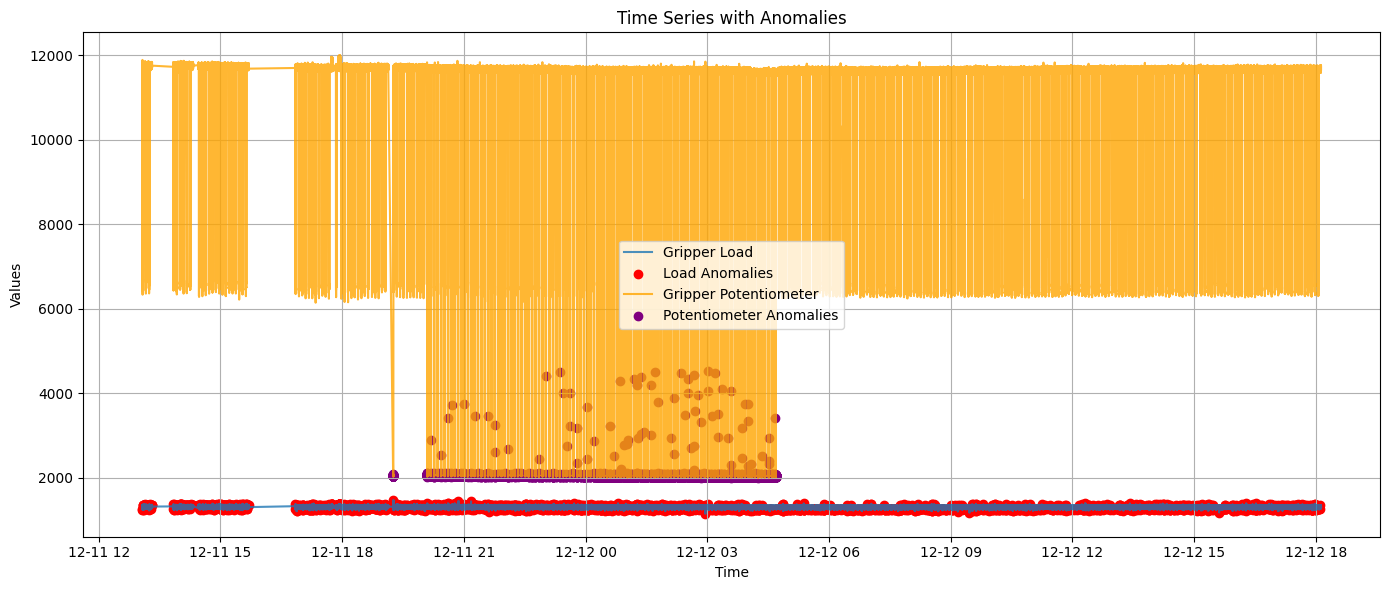

In [10]:
# Plot time series with anomalies
plt.figure(figsize=(14, 6))

# Gripper Load
plt.plot(data["_time"], data["I_R02_Gripper_Load"], label="Gripper Load", alpha=0.8)
plt.scatter(data["_time"][data["Load_Anomaly"]], data["I_R02_Gripper_Load"][data["Load_Anomaly"]], color="red", label="Load Anomalies")

# Gripper Potentiometer
plt.plot(data["_time"], data["I_R02_Gripper_Pot"], label="Gripper Potentiometer", alpha=0.8, color="orange")
plt.scatter(data["_time"][data["Pot_Anomaly"]], data["I_R02_Gripper_Pot"][data["Pot_Anomaly"]], color="purple", label="Potentiometer Anomalies")

plt.title("Time Series with Anomalies")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Hourly Anomalies:
 hour
0.0     3923
1.0     4443
2.0     4436
3.0     4681
4.0     3388
5.0      152
6.0      143
7.0      179
8.0      186
9.0      167
10.0     191
11.0     117
12.0     109
13.0     167
14.0     244
15.0     202
16.0     137
17.0     502
18.0     107
19.0     368
20.0    1494
21.0    1577
22.0    1687
23.0    1701
dtype: int64


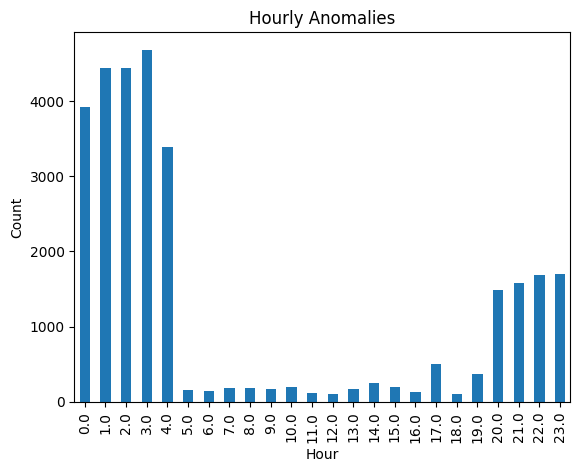

In [11]:
# Count anomalies by hour to spot patterns
data["hour"] = data["_time"].dt.hour
hourly_anomalies = data[data["Load_Anomaly"] | data["Pot_Anomaly"]].groupby("hour").size()
print("Hourly Anomalies:\n", hourly_anomalies)
hourly_anomalies.plot(kind="bar", title="Hourly Anomalies", xlabel="Hour", ylabel="Count")
plt.show()

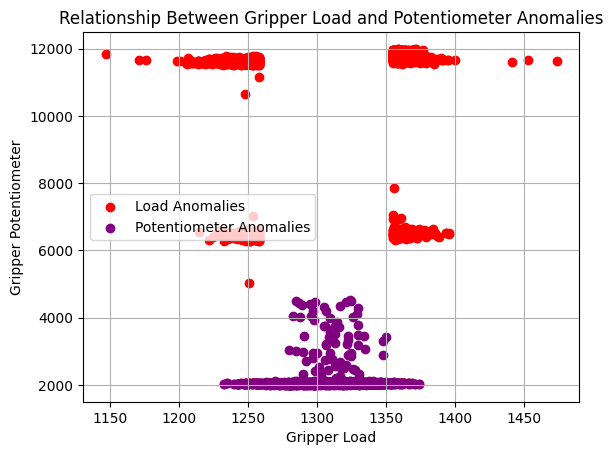

In [12]:
# Plot anomalies in scatter plot to examine relationship
plt.scatter(data["I_R02_Gripper_Load"][data["Load_Anomaly"]], data["I_R02_Gripper_Pot"][data["Load_Anomaly"]], color="red", label="Load Anomalies")

plt.scatter(data["I_R02_Gripper_Load"][data["Pot_Anomaly"]], data["I_R02_Gripper_Pot"][data["Pot_Anomaly"]], color="purple", label="Potentiometer Anomalies")

plt.xlabel("Gripper Load")
plt.ylabel("Gripper Potentiometer")
plt.legend()
plt.title("Relationship Between Gripper Load and Potentiometer Anomalies")
plt.grid(True)
plt.show()

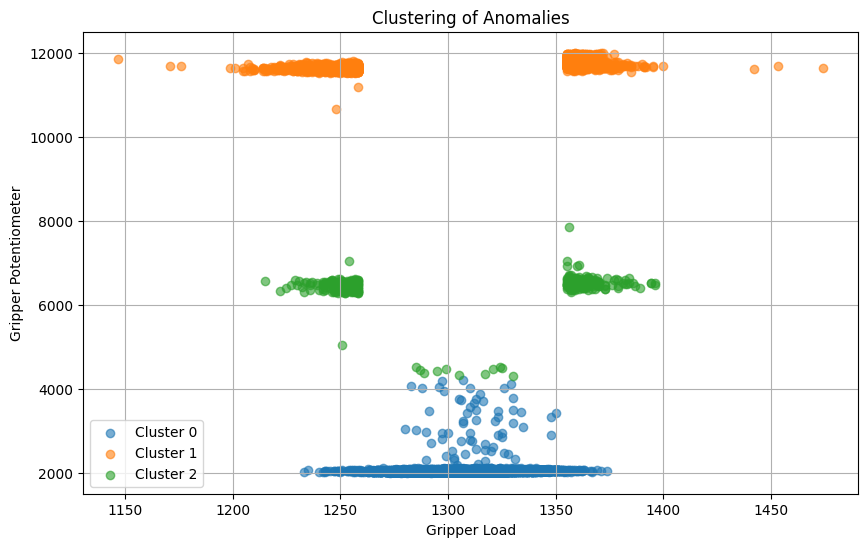

In [13]:
from sklearn.cluster import KMeans

# Select only the anomalies for clustering analysis
anomaly_data = data[(data["Load_Anomaly"]) | (data["Pot_Anomaly"])][["I_R02_Gripper_Load", "I_R02_Gripper_Pot"]]

# Set the number of clusters (experiment with different values)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
anomaly_data["Cluster"] = kmeans.fit_predict(anomaly_data)

# Visualize clustered anomalies
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    cluster_points = anomaly_data[anomaly_data["Cluster"] == i]
    plt.scatter(cluster_points["I_R02_Gripper_Load"], cluster_points["I_R02_Gripper_Pot"], label=f"Cluster {i}", alpha=0.6)

plt.xlabel("Gripper Load")
plt.ylabel("Gripper Potentiometer")
plt.legend()
plt.title("Clustering of Anomalies")
plt.grid(True)
plt.show()

In [14]:
# Create new time-based features
data["hour"] = data["_time"].dt.hour
data["day_of_week"] = data["_time"].dt.dayofweek
data["is_weekend"] = data["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)

# Preview the new features
data[["_time", "hour", "day_of_week", "is_weekend"]].head()

,_time,hour,day_of_week,is_weekend
0,2023-12-11 13:04:12.348,13.0,0.0,0
1,2023-12-11 13:04:12.439,13.0,0.0,0
2,2023-12-11 13:04:12.541,13.0,0.0,0
3,2023-12-11 13:04:12.637,13.0,0.0,0
4,2023-12-11 13:04:12.743,13.0,0.0,0


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Define features and target
features = ["I_R02_Gripper_Load", "I_R02_Gripper_Pot", "hour", "day_of_week", "is_weekend"]
target = data["Load_Anomaly"] | data["Pot_Anomaly"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[features], target, test_size=0.3, random_state=42)

# Train a Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[283246      0]
 [     0   9205]]

Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00    283246
        True       1.00      1.00      1.00      9205

    accuracy                           1.00    292451
   macro avg       1.00      1.00      1.00    292451
weighted avg       1.00      1.00      1.00    292451



In [16]:
import joblib

# Save the trained model to a file
joblib.dump(rf_model, "anomaly_detection_model.pkl")

print("Model saved as 'anomaly_detection_model.pkl'")

Model saved as 'anomaly_detection_model.pkl'


In [17]:
import joblib
import pandas as pd

# Load the saved model
model = joblib.load("anomaly_detection_model.pkl")

# Simulate incoming data (you can replace this with actual new data)
# For this example, we'll reuse a sample of the existing data
new_data = data.sample(100)  # Assume this is incoming data

# Ensure the same feature engineering is applied to new data
new_data["hour"] = new_data["_time"].dt.hour
new_data["day_of_week"] = new_data["_time"].dt.dayofweek
new_data["is_weekend"] = new_data["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)

# Select the features and predict anomalies
features = ["I_R02_Gripper_Load", "I_R02_Gripper_Pot", "hour", "day_of_week", "is_weekend"]
new_data["Predicted_Anomaly"] = model.predict(new_data[features])

# Display the prediction results
print(new_data[["_time", "I_R02_Gripper_Load", "I_R02_Gripper_Pot", "Predicted_Anomaly"]])

                         _time  I_R02_Gripper_Load  I_R02_Gripper_Pot  \
192555 2023-12-11 20:23:35.743                1298              11644   
497671 2023-12-12 04:52:19.034                1231              11583   
174896 2023-12-11 19:54:09.537                1344              11744   
648099 2023-12-12 09:03:03.546                1307              11636   
831855 2023-12-12 14:09:22.361                1308              11664   
...                        ...                 ...                ...   
411888 2023-12-12 02:29:19.752                1336              11688   
61910  2023-12-11 15:25:47.442                1304              11676   
474290 2023-12-12 04:13:20.442                1297              11583   
551404 2023-12-12 06:21:52.848                1324              11685   
929576 2023-12-12 16:52:15.744                1286              11684   

        Predicted_Anomaly  
192555              False  
497671               True  
174896              False  
648099     

In [19]:
# Include the '_time' column when selecting anomalies for clustering analysis
anomaly_data = data[(data["Load_Anomaly"]) | (data["Pot_Anomaly"])][["_time", "I_R02_Gripper_Load", "I_R02_Gripper_Pot"]]

# Run KMeans clustering and add cluster labels to the DataFrame
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
anomaly_data["Cluster"] = kmeans.fit_predict(anomaly_data[["I_R02_Gripper_Load", "I_R02_Gripper_Pot"]])

# Retry analysis by cluster
for i in range(n_clusters):
    cluster_data = anomaly_data[anomaly_data["Cluster"] == i]
    print(f"Cluster {i} Analysis:")
    print("Average Gripper Load:", cluster_data["I_R02_Gripper_Load"].mean())
    print("Average Gripper Potentiometer:", cluster_data["I_R02_Gripper_Pot"].mean())
    print("Anomaly Hour Distribution:\n", cluster_data["_time"].dt.hour.value_counts().sort_index())
    print("-" * 30)

Cluster 0 Analysis:
Average Gripper Load: 1310.0278905427756
Average Gripper Potentiometer: 2047.3606976394526
Anomaly Hour Distribution:
 _time
0.0     3808
1.0     4341
2.0     4342
3.0     4594
4.0     3260
19.0     264
20.0    1365
21.0    1489
22.0    1563
23.0    1574
Name: count, dtype: int64
------------------------------
Cluster 1 Analysis:
Average Gripper Load: 1280.6171617161717
Average Gripper Potentiometer: 11662.217821782178
Anomaly Hour Distribution:
 _time
0     112
1      99
2      91
3      85
4     124
5     144
6     128
7     163
8     180
9     157
10    175
11    104
12    105
13    138
14    208
15    170
16    116
17    472
18     84
19     85
20     98
21     75
22    110
23    110
Name: count, dtype: int64
------------------------------
Cluster 2 Analysis:
Average Gripper Load: 1309.546195652174
Average Gripper Potentiometer: 6427.451086956522
Anomaly Hour Distribution:
 _time
0      3
1      3
2      3
3      2
4      4
5      8
6     15
7     16
8      6
9 